## Image Processing

In [236]:
!pip install git+https://github.com/ArcetriAdaptiveOptics/OAO24.git

  Cloning https://github.com/ArcetriAdaptiveOptics/OAO24.git to /private/var/folders/yy/y6mh4b390sj24kqkcp9nl2c40000gp/T/pip-req-build-tpt33xf8
  Running command git clone --filter=blob:none --quiet https://github.com/ArcetriAdaptiveOptics/OAO24.git /private/var/folders/yy/y6mh4b390sj24kqkcp9nl2c40000gp/T/pip-req-build-tpt33xf8
  Resolved https://github.com/ArcetriAdaptiveOptics/OAO24.git to commit be04fe2770de6655e349821a97f216946cf4e4ee
  Preparing metadata (setup.py) ... done


In [237]:
import numpy as np
import matplotlib.pyplot as plt
from oao24 import package_data


In [238]:
class InfraredExampleData():
    
    @staticmethod
    def get_open_loop_data_cube():
        image =  np.load(package_data.tuto3_folder() / "ID_105.npy")
        return np.atleast_3d(image)
    
    @staticmethod
    def get_camera_dark_data():
        return np.load(package_data.tuto3_folder() / "ID_110.npy")
    
    @staticmethod
    def get_close_loop_data_cube():
        return np.load(package_data.tuto3_folder() / "ID_109_red_16.npy")

Write a method that implements raw images cleanup for the infrared detector
Implements sky subtractions and cube stacking

In [239]:
def print_roi_mean_values(image, label=''):
    '''
    Print mean values of 4 Region Of Interest in the corners 
    of the image.
    Return average value in the ROIs
    We use it as background value indicator
    '''
    bkg_roi1 = image[50:100, 50:100].mean()
    bkg_roi2 = image[50:100, -100:-50].mean()
    bkg_roi3 = image[-100:-50, 50:100].mean()
    bkg_roi4 = image[-100:-50, -100:-50].mean()
    bkg = np.mean([bkg_roi1, bkg_roi2, bkg_roi3, bkg_roi4]) 
    print("%s : ROIs mean values %g %g %g %g - Average %g ADU" % (label, bkg_roi1, bkg_roi2, bkg_roi3, bkg_roi4, bkg) )
    return bkg



def make_master_image(raw_data_cube, background_image):
    ''' 
    Compute the master image from a raw cube data and the background image.
    
    1. Dark image is subtracted to each image of the raw cube
    2. Cube is cumulated (without shift and add)
    
    Dark_image must have the same camera setting
    (i.e. exposure and filter) of each image of the raw cube
    '''    
    
    Nframes = raw_data_cube.shape[-1]
    
    # display the background image
    plt.figure()
    plt.imshow(background_image, vmin=0,vmax=2000)
    #plt.imshow(background_image)
    plt.colorbar(label = 'ADU')
    plt.title("Background image")
    print_roi_mean_values(background_image, label='Background')
 
    # display one frame of the raw data cube
    plt.figure()
    plt.imshow(raw_data_cube[:,:,0], vmin=0, vmax=2000)
    plt.colorbar(label = 'ADU')
    plt.title("Raw data image #0")
    print_roi_mean_values(raw_data_cube[:,:,0], label='Raw image #0')
    
    
    # subtracting background from raw data
    # make sure new array is float !!! to avoid integer overflows
    background_subtracted_data_cube = np.zeros(raw_data_cube.shape, dtype=float)
    for frame in np.arange(Nframes):
        background_subtracted_data_cube[:, :, frame] = raw_data_cube[ :, :, frame] - background_image
    

    ##########  Computing master image
    # Sum along the NDIT dimension to obtain a single (512,640) image
    # Must know total integration time
    # 
    # Advanced: shift & add. Detects every image's maximum and shift 
    # every image before stacking to eliminate residual tip-tilt
    ###########    
    master_image = background_subtracted_data_cube.sum(axis = -1)
    print_roi_mean_values(master_image, label='Master image')

    
    #########
    # Check background subtraction is ok.
    # Dark area should be around 0 
    ######
    plt.figure()
    plt.imshow(master_image, vmin=-10, vmax=100)
    plt.title('Master image (linear scale, clipped)')
    plt.colorbar()

    #########
    # Display image 
    # Dark area should be around 0 
    ######
    plt.figure()
    arr=master_image
    plt.imshow(np.log10(arr-np.median(arr)+1), cmap='inferno')
    plt.title('Master image (log scale)')
    plt.colorbar()
        
    return master_image

Background : ROIs mean values 1576.42 1467.13 1498.06 1399.82 - Average 1485.36 ADU
Raw image #0 : ROIs mean values 1575.78 1466.97 1497.42 1399.45 - Average 1484.9 ADU
Master image : ROIs mean values 2.12017 2.77187 1.11106 2.13341 - Average 2.03413 ADU


/var/folders/yy/y6mh4b390sj24kqkcp9nl2c40000gp/T/ipykernel_75640/810313357.py:80: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(arr-np.median(arr)+1), cmap='inferno')
/var/folders/yy/y6mh4b390sj24kqkcp9nl2c40000gp/T/ipykernel_75640/810313357.py:80: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(arr-np.median(arr)+1), cmap='inferno')


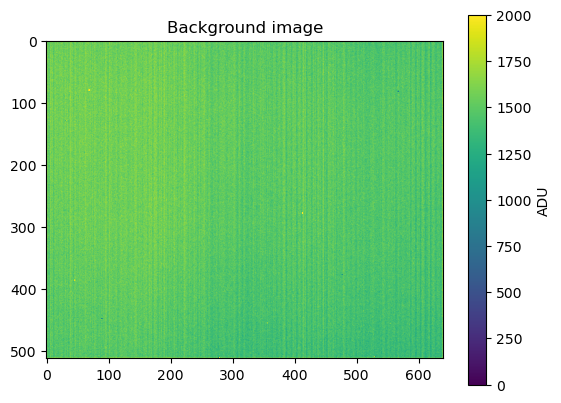

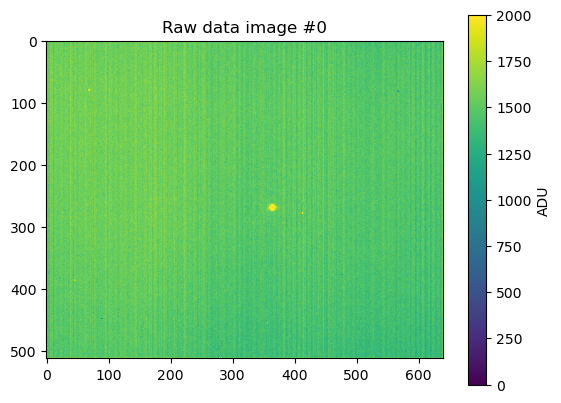

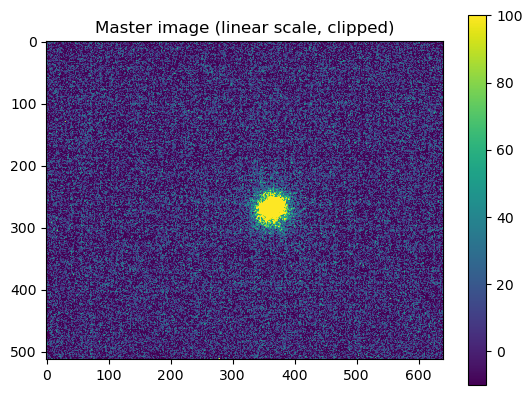

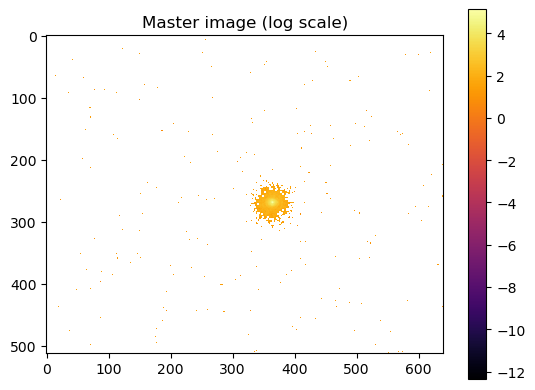

In [240]:
background_image = InfraredExampleData.get_camera_dark_data()
cl_raw_image_cube = InfraredExampleData.get_close_loop_data_cube()
    
cl_master = make_master_image(cl_raw_image_cube, background_image)

Background : ROIs mean values 1576.42 1467.13 1498.06 1399.82 - Average 1485.36 ADU
Raw image #0 : ROIs mean values 1576.24 1466.97 1497.94 1399.69 - Average 1485.21 ADU
Master image : ROIs mean values -0.183862 -0.152807 -0.114384 -0.13293 - Average -0.145996 ADU


/var/folders/yy/y6mh4b390sj24kqkcp9nl2c40000gp/T/ipykernel_75640/810313357.py:80: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(arr-np.median(arr)+1), cmap='inferno')
/var/folders/yy/y6mh4b390sj24kqkcp9nl2c40000gp/T/ipykernel_75640/810313357.py:80: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(arr-np.median(arr)+1), cmap='inferno')


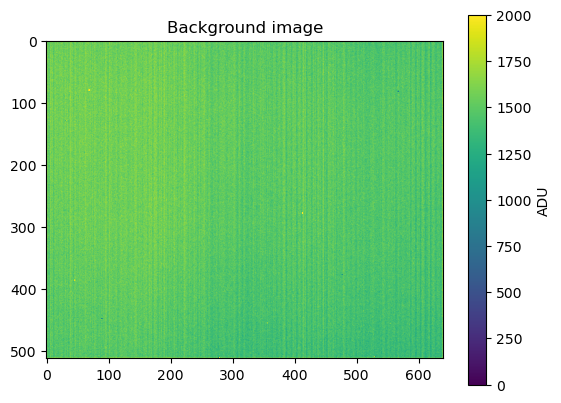

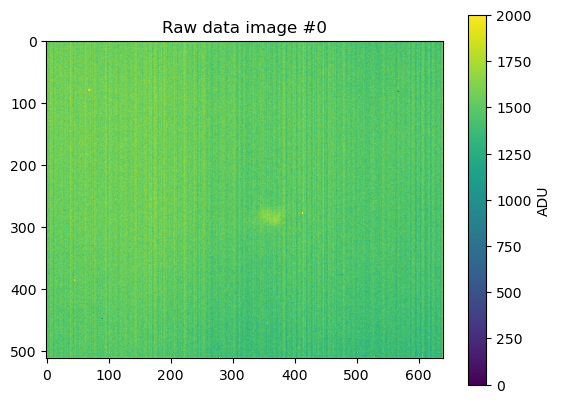

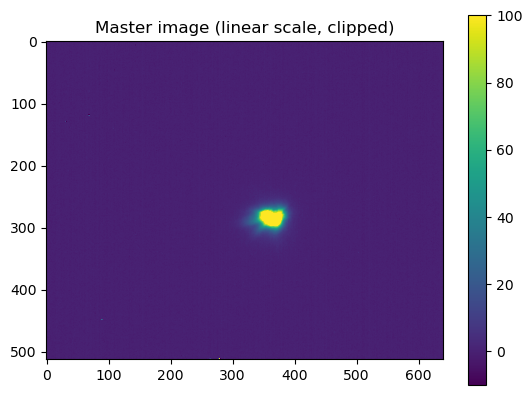

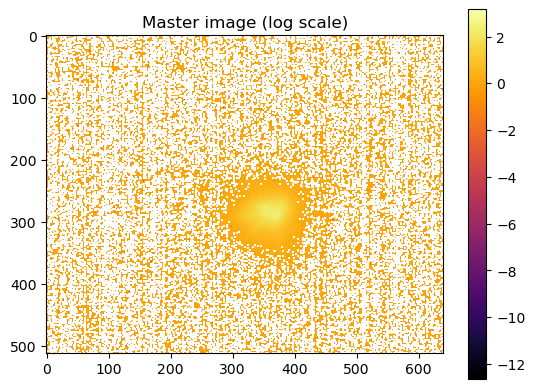

In [241]:
background_image = InfraredExampleData.get_camera_dark_data()
ol_raw_image_cube = InfraredExampleData.get_open_loop_data_cube()    
ol_master = make_master_image(ol_raw_image_cube, background_image)

Display open loop and closed loop images
Zoom on the PSF, get rid of negative values to log-display

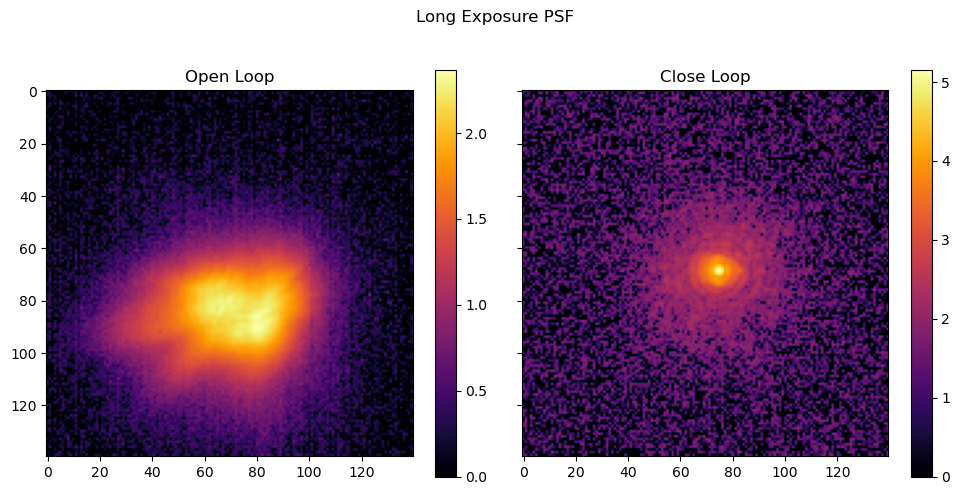

In [242]:
ol_ima = ol_master[200:340, 290:430]
cl_ima = cl_master[200:340, 290:430]


fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))  # Adjusting figure size for better layout
fig.suptitle('Long Exposure PSF')

# Plot the first image and its colorbar (Open Loop)
im0 = axs[0].imshow(np.log10(np.clip(ol_ima, 0, None) + 1), cmap='inferno')
axs[0].title.set_text('Open Loop')
fig.colorbar(im0, ax=axs[0])  # Add colorbar to the first plot

# Plot the second image and its colorbar (Close Loop)
im1 = axs[1].imshow(np.log10(np.clip(cl_ima, 0, None) + 1), cmap='inferno')
axs[1].title.set_text('Close Loop')
fig.colorbar(im1, ax=axs[1])  # Add colorbar to the second plot

fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout so that title doesn't overlap with the subplots
plt.show()


Questions:
1. We should add saturation checks
2. Shift & Add?  
3. What about bad pixels (cold or hot)? How to detect them? How to fix them?


NB: This is only image cleanup
1. We didn't touch photometry, ADU->flux conversion, etc...
2. We didn't touch astrometry, pixel scale, distortions, etc...